# **Time Series Forcasting**

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import scipy 
import matplotlib.pyplot as plt
import ast
from scipy.interpolate import make_interp_spline
from scipy.fft import fft,ifft
import warnings
warnings.filterwarnings("ignore")

In [3]:
dataset = pd.read_csv('/content/drive/MyDrive/Deep_learning/airline-price-prediction.csv')
#dataset = pd.read_csv('airline-price-prediction.csv')
dataset.head()

,date,airline,ch_code,num_code,dep_time,time_taken,stop,arr_time,type,route,price
0,5/3/2022,Vistara,UK,812,9:45,10h 10m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,19:55,business,"{'source': 'Bangalore', 'destination': 'Hydera...","56,588"
1,18-03-2022,Vistara,UK,975,5:45,06h 30m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,12:15,business,"{'source': 'Delhi', 'destination': 'Hyderabad'}","59,649"
2,9/3/2022,GO FIRST,G8,7537,14:30,08h 10m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,22:40,economy,"{'source': 'Mumbai', 'destination': 'Hyderabad'}","3,916"
3,15-03-2022,GO FIRST,G8,287,10:40,09h 40m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:20,economy,"{'source': 'Mumbai', 'destination': 'Delhi'}","6,031"
4,22-03-2022,Vistara,UK,826,12:30,07h 25m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,19:55,economy,"{'source': 'Chennai', 'destination': 'Kolkata'}","7,081"


In [4]:
np.sum(dataset.duplicated())

0

Exploring the data types of the features

In [5]:
dataset.dtypes

date          object
airline       object
ch_code       object
num_code       int64
dep_time      object
time_taken    object
stop          object
arr_time      object
type          object
route         object
price         object
dtype: object

In [6]:
np.sum(dataset.isna())

date          0
airline       0
ch_code       0
num_code      0
dep_time      0
time_taken    0
stop          0
arr_time      0
type          0
route         0
price         0
dtype: int64

# These columns are one of 2 things :
1. Either a format fix of an original feature
2. A new feature I am going to extract from the data

In [7]:
dataset['full_information_timestamp'] = 0
dataset['flight_day'] = 0
dataset['flight_month'] = 0
dataset['week_day_of_flight'] = 0
dataset['num_of_hours_taken'] =0
dataset['num_of_stops'] = 0
dataset['one_stop_in'] = 'Not Found'
dataset['distance_between_2_cities'] = 0
dataset['source'] = 0
dataset['destination'] = 0
dataset['formatted_price'] =0

# **1.Date**

There were 2 ways to explain to python that date feature was of type datetime, one way was to convert it using pandas to datetime but unfortunately the month and the day were swapped in the new format as some observations were in the right format ( example : month is '02' ) and other observations were in the wrong format ( example : month is '2' ), so the other approach was to do it manually

In [8]:
def format_date(date):
    dashed_date = date.replace('/','-')
    return dashed_date

In [9]:
dataset['full_information_timestamp'] = dataset.date.apply(lambda date:format_date(date))

Extracting the day of the month and the month, and choosing a datetime format where the month is explicitly mentioned and there is no way for error in swapping the day with the month

In [10]:
def extract_day_month(date):
    splitted_date = date.split('-')
    day = int(splitted_date[0])
    month =int(splitted_date[1])
    if splitted_date[1]== '2' or splitted_date[1]== '02':
        new_date_format = 'February ' + splitted_date[0] + ', '+ splitted_date[2]
    else :
        new_date_format = 'March ' + splitted_date[0] + ', '+ splitted_date[2]
    return day,month,new_date_format

In [11]:
dataset[['flight_day', 'flight_month','full_information_timestamp']] = pd.DataFrame(dataset.full_information_timestamp.apply(lambda date: extract_day_month(date)).tolist(), index=dataset.index)

Pandas datetime has a lot of features that can be extracted easily from the date, like the day of the week which I believe is an important feature (some flights maybe cheaper/ more expensive on a specific day)

In [12]:
dataset['full_information_timestamp'] = pd.to_datetime(dataset['full_information_timestamp'])

In [13]:
def extract_weekday(day):
    return day.day_name()

In [14]:
dataset['week_day_of_flight'] = dataset.full_information_timestamp.apply(lambda date:extract_weekday(date))

# Since this is a time series data, data must be sorted according to the date, from older to newer, to prevent data leakage when splitting the data into a training and a testing set.
# Since there were many observations belonging to the same day, the data also had to be sorted according to the hour and minute of the time of flight departure

The datetime is an immutable object, so if we wanted to change the hour and minute, a new object had to be made with the hour and minute that we want, then we may change the variable itself with the new one

In [15]:
def embed_time_details_into_date(time,departure_time):
    hours_minutes = departure_time.split(':')
    full_information_timestamp = time.replace(hour=int(hours_minutes[0]),minute=int(hours_minutes[1]))
    return full_information_timestamp

In [16]:
dataset['full_information_timestamp']= dataset.apply(lambda dataFrame: embed_time_details_into_date(dataFrame['full_information_timestamp'], dataFrame['dep_time']),axis=1)

In [17]:
dataset[['full_information_timestamp']]

,full_information_timestamp
0,2022-03-05 09:45:00
1,2022-03-18 05:45:00
2,2022-03-09 14:30:00
3,2022-03-15 10:40:00
4,2022-03-22 12:30:00
...,...
240203,2022-03-25 09:55:00
240204,2022-02-15 19:10:00
240205,2022-02-23 22:50:00
240206,2022-02-11 17:35:00


In [18]:
dataset.head()

,date,airline,ch_code,num_code,dep_time,time_taken,stop,arr_time,type,route,...,flight_day,flight_month,week_day_of_flight,num_of_hours_taken,num_of_stops,one_stop_in,distance_between_2_cities,source,destination,formatted_price
0,5/3/2022,Vistara,UK,812,9:45,10h 10m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,19:55,business,"{'source': 'Bangalore', 'destination': 'Hydera...",...,5,3,Saturday,0,0,Not Found,0,0,0,0
1,18-03-2022,Vistara,UK,975,5:45,06h 30m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,12:15,business,"{'source': 'Delhi', 'destination': 'Hyderabad'}",...,18,3,Friday,0,0,Not Found,0,0,0,0
2,9/3/2022,GO FIRST,G8,7537,14:30,08h 10m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,22:40,economy,"{'source': 'Mumbai', 'destination': 'Hyderabad'}",...,9,3,Wednesday,0,0,Not Found,0,0,0,0
3,15-03-2022,GO FIRST,G8,287,10:40,09h 40m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:20,economy,"{'source': 'Mumbai', 'destination': 'Delhi'}",...,15,3,Tuesday,0,0,Not Found,0,0,0,0
4,22-03-2022,Vistara,UK,826,12:30,07h 25m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,19:55,economy,"{'source': 'Chennai', 'destination': 'Kolkata'}",...,22,3,Tuesday,0,0,Not Found,0,0,0,0


# **2. Airline**

#There are two types of a class imbalace
1. Label imbalance -> where one label is dominating 
2. Feature imbalance -> where a class in a specific feature is the one that appears the most

To avoid feature imbalance we can calculate the percentage of the classes in each feature and those features of low frequencies in the observations can all be put in an "Others" class

In [19]:
def get_feature_percentage():
    size = dataset.shape[0]
    ctr = 0
    for index in dataset.airline.value_counts().index:
        percentage = (int(dataset.airline.value_counts()[ctr])/size)*100
        print("Airline '{index}' represents '{percentage}' of the data".format(index = index,percentage =percentage))
        ctr += 1

In [20]:
get_feature_percentage()

Airline 'Vistara' represents '42.53688469992673' of the data
Airline 'Air India' represents '26.957470192499834' of the data
Airline 'Indigo' represents '14.392110171184974' of the data
Airline 'GO FIRST' represents '7.752031572637049' of the data
Airline 'AirAsia' represents '5.322470525544528' of the data
Airline 'SpiceJet' represents '3.004063145274096' of the data
Airline 'StarAir' represents '0.019982681675880902' of the data
Airline 'Trujet' represents '0.014987011256910678' of the data


Airlines Vistara, Air India, and Indigo form 82% of the feature, so we can safely put all other airlines in the other class

In [21]:
def remove_low_frequency_airlines():
    high_frequency_airlines =['Vistara','Air India','Indigo']
    dataset ['airline'] = [airline if airline in high_frequency_airlines else 'Other_airline' for airline in dataset['airline']]
   

In [22]:
remove_low_frequency_airlines()

In [23]:
get_feature_percentage()

Airline 'Vistara' represents '42.53688469992673' of the data
Airline 'Air India' represents '26.957470192499834' of the data
Airline 'Other_airline' represents '16.11353493638846' of the data
Airline 'Indigo' represents '14.392110171184974' of the data


# **4. Ch_code**

There is a 100% dependancy between ch_code and the airline, as the ch_code is a code for the airline, so using both would cause redundancy while training, so this feature will be dropped

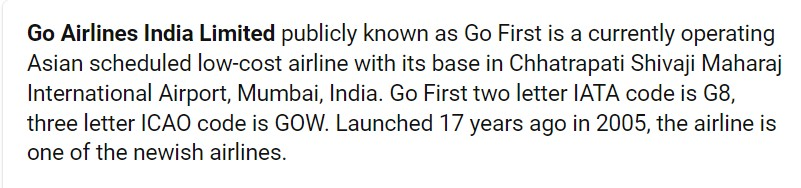

In [24]:
dataset.airline.value_counts()

Vistara          102177
Air India         64754
Other_airline     38706
Indigo            34571
Name: airline, dtype: int64

In [25]:
dataset.ch_code.value_counts()

UK    102177
AI     64754
6E     34571
G8     18621
I5     12785
SG      7216
S5        48
2T        36
Name: ch_code, dtype: int64

# **5. Departure time**
# **6. Time taken**
# **8. Arrival time**

The time taken is specified by the number of hours and the number of miutes, since we are using the hours only, to make use of the minutes, if the number of minutes exceeded 40 (our chosen threshold) we add 1 to the hours
Some corner cases might be that there are no minutes (ex : 7 h) and another corner case is that the hour and minutes are represented in the hours (ex : 1.4 h )

In [26]:
def calculate_time_taken(time_taken):
    time = time_taken.split(' ')
    float_hour = time[0].split('.')
    hours = 0
    if(len(float_hour)>1):
        time[0] = float_hour[0] + 'h'
        time[1]= float_hour[1][:-1] + time[1]
    if time[1][:-1] != '' : 
        if int(time[1][:-1]) >= 40 :
            hours = int(time[0][:-1]) + 1
        else :
            hours = int(time[0][:-1]) 
    else :
        hours = int(time[0][:-1])
    return hours

In [27]:
dataset['num_of_hours_taken'] = dataset.time_taken.apply(lambda time_taken: calculate_time_taken(time_taken))

There is a 100% dependency between arrival time, departure time and time taken, and this dependency can be expressed by : time taken = arrival time - departure time.

Since using the hours themselves in arrival time and departure time will cause redundancy during training, we can extract the time of the day the flight departed and arrived as some times maybe cheaper or more expensive

In [28]:
def categorize_time(time):
    hours = time.split(':')
    hours[0] = int(hours[0])
    if hours[0] <6:
        return 'Early morning'
    elif 6<= hours[0] < 12 :
        return 'Morning'
    elif 12<= hours[0] < 18:
        return 'Afternoon'
    else:
        return 'Evening'

In [29]:
dataset['dep_time'] = dataset.dep_time.apply(lambda time: categorize_time(time))

In [30]:
dataset['arr_time'] = dataset.arr_time.apply(lambda time: categorize_time(time))

# **7. Stop**

In [31]:
dataset.stop.value_counts()

1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t\t\t\t                      194814
non-stop                                                                         28944
2+-stop                                                                          10612
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia IXU\n\t\t\t\t\t\t\t\t\t\t\t\t                 1487
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia IDR\n\t\t\t\t\t\t\t\t\t\t\t\t                 1099
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Patna\n\t\t\t\t\t\t\t\t\t\t\t\t                559
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Indore\n\t\t\t\t\t\t\t\t\t\t\t\t               299
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia PAT\n\t\t\t\t\t\t\t\t\t\t\t\t                  273
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia MYQ\n\t\t\t\t\t\t\t\t\t\t\t\t                  267
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Bhubaneswar\n\t\t\t\t\t\t\t\t\t\t\t\t          248
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia KLH\n\t\t\t\t\t\t\t\t\t\t\t\t                  231
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia JGB\n\t

In [32]:
def split_num_of_stops(stop):
    if stop[:8] == 'non-stop':
        stop_count = 0
    elif stop[:6] == '1-stop':
        stop_count = 1
    else:
        stop_count = 2
    return stop_count

In [33]:
dataset['num_of_stops']= dataset.stop.apply(lambda stop:split_num_of_stops(stop))

In [34]:
def find_where_is_the_stop(stop):
        if stop[:6] == '1-stop':
            splitted = stop.split(' ')
            if len(splitted)>1:
                fine_splitting = splitted[1].split('\n')
                return fine_splitting[0]

In [35]:
dataset['one_stop_in']=dataset.stop.apply(lambda stop:find_where_is_the_stop(stop))

In [36]:
dataset.one_stop_in.value_counts()

IXU               1487
IDR               1099
Patna              559
Indore             299
PAT                273
MYQ                267
Bhubaneswar        248
KLH                231
JGB                149
JRG                135
STV                129
Delhi              123
BBI                119
Hyderabad          107
IXE                 91
Ranchi              86
Raipur              78
Chennai             64
Guwahati            46
Mangalore           35
Mysore              33
Mumbai              27
VTZ                 22
Nagpur              21
Kolkata             18
NDC                 17
RPR                 16
Surat               11
Lucknow             11
GOP                 10
Vishakhapatnam       7
NAG                  7
Kolhapur             4
GAU                  3
IXR                  3
GAY                  2
HYD                  1
Name: one_stop_in, dtype: int64

Most of the observations either the stop is not mentioned, or there wasn't a stop, the highest frequency is the 'Not Found', so it is safe to put all other stops in a class which represents that the stop is 'Found'

In [37]:
dataset['one_stop_in'] = [0 if stop == 'Not found' else 1 for stop in dataset ['one_stop_in']]

# **9. Type**

We chose 1 to represent business class as it will always be more exprensive that the economy class, so the model could train a large weight for it only used in business

In [38]:
dataset['type'] = [1 if kind_of_trip == 'business' else 0 for kind_of_trip in dataset['type']]

# **10. Route**

Here I am using the abstract syntax tree library to change the strings in route feature to a dictionary so that accessing the source and destination would be easy

In [39]:
def split_route(route):
    path = ast.literal_eval(route)
    source = path['source']
    destination = path['destination']
    return source,destination

In [40]:
dataset[['source', 'destination']] = pd.DataFrame(dataset.route.apply(lambda route: split_route(route)).tolist(), index=dataset.index)

The distance between the 2 countries might be and important feature

(yes I searched for the distance between all of them :) , also the distance is in kilometers)

In [41]:
distances = dict()
distances['Mumbai','Kolkata'] = 2167
distances['Mumbai','Hyderabad'] = 721
distances['Mumbai','Chennai'] = 1344
distances['Mumbai','Bangalore'] = 995
distances['Mumbai','Delhi'] = 1439
distances['Delhi','Bangalore'] = 2169
distances['Delhi','Kolkata'] = 1554
distances['Delhi','Hyderabad'] = 1579
distances['Delhi','Chennai'] = 2202
distances['Bangalore','Kolkata']= 1560
distances['Bangalore','Hyderabad'] = 569
distances['Bangalore','Chennai'] = 348
distances['Kolkata','Hyderabad'] = 1489
distances['Kolkata','Chennai'] = 1663
distances['Hyderabad','Chennai'] = 628

In [42]:
def calculate_distance(source,destination):
    try :
        dist = distances[source,destination]
    except :
        dist = distances[destination,source]
    return dist

In [43]:
dataset['distance_between_2_cities'] = dataset.apply(lambda dataFrame: calculate_distance(dataFrame['source'], dataFrame['destination']), axis=1)
dataset['distance_between_2_cities'] = dataset['distance_between_2_cities']/dataset['distance_between_2_cities'].max()

In [44]:
dataset.head()

,date,airline,ch_code,num_code,dep_time,time_taken,stop,arr_time,type,route,...,flight_day,flight_month,week_day_of_flight,num_of_hours_taken,num_of_stops,one_stop_in,distance_between_2_cities,source,destination,formatted_price
0,5/3/2022,Vistara,UK,812,Morning,10h 10m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,Evening,1,"{'source': 'Bangalore', 'destination': 'Hydera...",...,5,3,Saturday,10,1,1,0.258401,Bangalore,Hyderabad,0
1,18-03-2022,Vistara,UK,975,Early morning,06h 30m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,Afternoon,1,"{'source': 'Delhi', 'destination': 'Hyderabad'}",...,18,3,Friday,6,1,1,0.717075,Delhi,Hyderabad,0
2,9/3/2022,Other_airline,G8,7537,Afternoon,08h 10m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,Evening,0,"{'source': 'Mumbai', 'destination': 'Hyderabad'}",...,9,3,Wednesday,8,1,1,0.327430,Mumbai,Hyderabad,0
3,15-03-2022,Other_airline,G8,287,Morning,09h 40m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,Evening,0,"{'source': 'Mumbai', 'destination': 'Delhi'}",...,15,3,Tuesday,10,1,1,0.653497,Mumbai,Delhi,0
4,22-03-2022,Vistara,UK,826,Afternoon,07h 25m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,Evening,0,"{'source': 'Chennai', 'destination': 'Kolkata'}",...,22,3,Tuesday,7,1,1,0.755223,Chennai,Kolkata,0


# **11. Price**

The price is an object due to the presence of a comma, and this needs to be fixed

In [45]:
def fix_price_format(price):
    number = price.split(',')
    cost = number[0] + number[1]
    cost=int(cost)
    return cost

In [46]:
dataset['formatted_price'] = dataset.price.apply(lambda price:fix_price_format(price))

After getting the price in the right format, it is always a good idea to search for the outliers as the outliers in some problems are noise to the data and they skew the predictions 

In [47]:
dataset.shape

(240208, 22)

In [48]:
def get_outliers_boundaries():
    first_quartile = np.percentile(dataset['formatted_price'],25)
    third_quartile = np.percentile(dataset['formatted_price'],75)
    interquartile_range = third_quartile - first_quartile
    floor = first_quartile - 1.5 * interquartile_range
    cieling = third_quartile + 1.5 * interquartile_range
    #it doesnt make sense to have a negative price
    if floor < 0:
        floor = 0
    outliers = []
    for observation in range(len(dataset['formatted_price'])):
        if dataset['formatted_price'][observation] < floor or dataset['formatted_price'][observation] > cieling:
            outliers.append(dataset['formatted_price'][observation])
            dataset.drop(observation,axis=0,inplace=True)
    print("The outliers are '{values}'".format(values=outliers))

In [49]:
get_outliers_boundaries()

The outliers are '[99204, 99327, 99584, 99204, 99403, 98972, 99584, 99327, 99551, 99129, 99677]'


In [50]:
dataset.shape

(240197, 22)

Here we are exploring the shape of the data based on the month, this will be used when transforming the data into the frequency domain, this function is made to represents the average of the prices of each day in a specific month

In [51]:
def draw_periodic_signal(dataFrame,condition,grouping_column,condition_column,label):
    df = dataFrame[dataFrame[condition_column]==condition]
    df = df.groupby(grouping_column)[[label]].mean()
    x_values = np.array(df.index)
    y_values = np.array(df[label])
    X_Y_Spline = make_interp_spline(np.array(x_values), y_values)
    X_ = np.linspace(x_values.min(), x_values.max(), 400)
    Y_ = X_Y_Spline(X_)
    plt.plot(X_,Y_)
    plt.show()

#We cannot form an exact opinion based on the observations of Febrauary, as our observations start from 11/2, and the data of the beginning of the month is lost

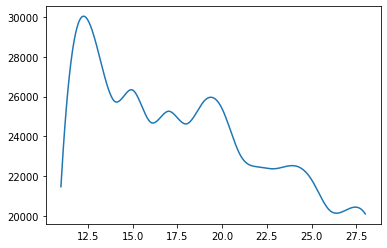

In [52]:
draw_periodic_signal(dataset,2,'flight_day','flight_month','formatted_price')

#But we have all the data belonging to March

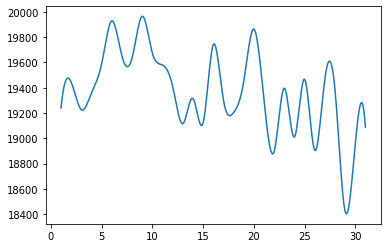

In [53]:
draw_periodic_signal(dataset,3,'flight_day','flight_month','formatted_price')

# The data looks like a signal in the time domain, and since this is a time series data, we can transform the data to the frequency domain to get the most effective frequency componenets 

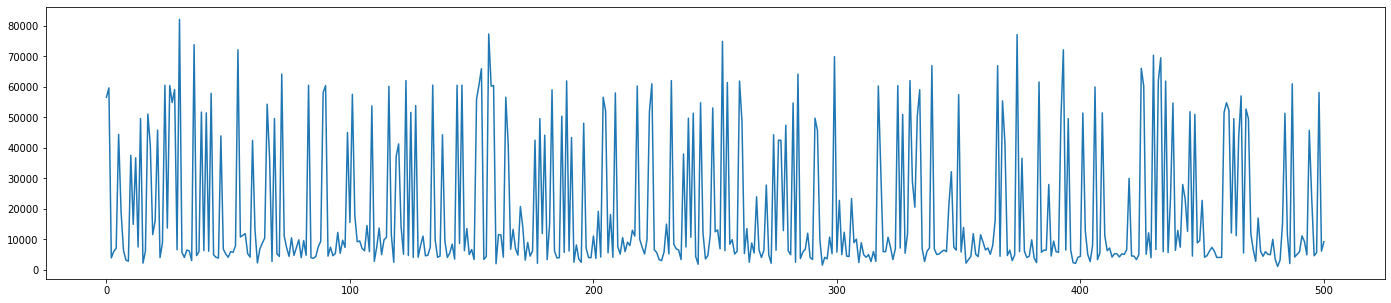

In [55]:
dataset['formatted_price'][:500].plot(figsize=(24,5))
plt.show()

In [56]:
dataset.sort_values(by ='full_information_timestamp',inplace =True,kind = 'mergesort',ascending = True)

In [57]:
dataset.drop(columns=['date','ch_code','time_taken','stop','route','price','full_information_timestamp','num_code'],axis = 1,inplace=True)

In [58]:
dataset.head()

,airline,dep_time,arr_time,type,flight_day,flight_month,week_day_of_flight,num_of_hours_taken,num_of_stops,one_stop_in,distance_between_2_cities,source,destination,formatted_price
6760,Other_airline,Early morning,Morning,0,11,2,Friday,2,0,1,0.653497,Delhi,Mumbai,5956
167590,Other_airline,Early morning,Afternoon,0,11,2,Friday,10,1,1,0.985014,Delhi,Bangalore,7423
5914,Other_airline,Early morning,Afternoon,0,11,2,Friday,11,1,1,0.985014,Delhi,Bangalore,21343
94844,Other_airline,Early morning,Afternoon,0,11,2,Friday,7,1,1,0.985014,Delhi,Bangalore,7423
96663,Other_airline,Early morning,Evening,0,11,2,Friday,14,1,1,0.985014,Delhi,Bangalore,21343


# As the data is full of categories, there are many approaches to change categorical data to numerical ones, like the one hot encoding and target encoding, so I copied the data into another variable and both were done:
1.  Applied to one the target encoding, and I encoded the categories based on the average of their prices (as it is my label and what I want to reach)
2. Applied to the other the one hot encoding

In [59]:
target_encoded_dataset = dataset.copy()

In [60]:
dataset.groupby('dep_time')[['formatted_price']].mean()

,formatted_price
dep_time,
Afternoon,19367.829652
Early morning,11522.921204
Evening,22113.862170
Morning,21762.739775


In [61]:
def arranging_dep_time_by_price(time):
    if time =='Early morning':
        return 1
    elif time == 'Afternoon':
        return 2
    elif time == 'Morning':
        return 3
    else :
        return 4

In [62]:
target_encoded_dataset['dep_time'] = target_encoded_dataset.dep_time.apply(lambda time: arranging_dep_time_by_price(time))

Arrival time ordered by price is the same as departure time so we can use the same function

In [63]:
dataset.groupby('arr_time')[['formatted_price']].mean()

,formatted_price
arr_time,
Afternoon,19817.742884
Early morning,11210.585402
Evening,22267.583780
Morning,20994.180518


In [64]:
target_encoded_dataset['arr_time'] = target_encoded_dataset.arr_time.apply(lambda time: arranging_dep_time_by_price(time))

In [65]:
dataset.groupby('week_day_of_flight')[['formatted_price']].mean()

,formatted_price
week_day_of_flight,
Friday,20639.748577
Monday,20787.233494
Saturday,21356.527991
Sunday,21418.268188
Thursday,20506.297795
Tuesday,20455.409516
Wednesday,20604.695975


In [66]:
def arranging_day_by_price(day):
    if day =='Tuesday' :
        return 1
    elif day =='Thursday' :
        return 2
    elif day =='Wednesday' :
        return 3
    elif day =='Friday' :
        return 4
    elif day =='Monday' :
        return 5
    elif day =='Saturday' :
        return 6
    else :
        return 7

In [67]:
target_encoded_dataset['week_day_of_flight'] = target_encoded_dataset.week_day_of_flight.apply(lambda day: arranging_day_by_price(day))

In [68]:
dataset.groupby('airline')[['formatted_price']].mean()

,formatted_price
airline,
Air India,23441.239985
Indigo,5322.844060
Other_airline,5226.251331
Vistara,30307.632167


In [69]:
def arranging_airline_by_price(airline):
    if airline == 'Other_airline' :
        return 1
    elif airline == 'Indigo' :
        return 2
    elif airline == 'Air India' :
        return 3
    else :
        return 4

In [70]:
target_encoded_dataset['airline'] = target_encoded_dataset.airline.apply(lambda airline: arranging_airline_by_price(airline))

In [71]:
dataset.groupby('source')[['formatted_price']].mean()

,formatted_price
source,
Bangalore,21499.373150
Chennai,21909.798122
Delhi,18868.462971
Hyderabad,20012.072367
Kolkata,21649.666550
Mumbai,21412.577749


In [72]:
def arranging_source_by_price(source):
    if source == 'Delhi' :
        return 1
    elif source == 'Hyderabad' :
        return 2
    elif source == 'Mumbai' :
        return 3
    elif source == 'Bangalore' :
        return 4
    elif source == 'Kolkata' :
        return 5
    else :
        return 6

In [73]:
target_encoded_dataset['source'] = target_encoded_dataset.source.apply(lambda source: arranging_source_by_price(source))

In [74]:
dataset.groupby('destination')[['formatted_price']].mean()

,formatted_price
destination,
Bangalore,21520.162803
Chennai,21845.924328
Delhi,18338.150235
Hyderabad,20457.298224
Kolkata,21915.423038
Mumbai,21259.062462


In [75]:
def arranging_destination_by_price(source):
    if source == 'Delhi' :
        return 1
    elif source == 'Hyderabad' :
        return 2
    elif source == 'Mumbai' :
        return 3
    elif source == 'Bangalore' :
        return 4
    elif source == 'Chennai' :
        return 5
    else :
        return 6

In [76]:
target_encoded_dataset['destination'] = target_encoded_dataset.destination.apply(lambda destination: arranging_destination_by_price(destination))

In [77]:
target_encoded_dataset.head()

,airline,dep_time,arr_time,type,flight_day,flight_month,week_day_of_flight,num_of_hours_taken,num_of_stops,one_stop_in,distance_between_2_cities,source,destination,formatted_price
6760,1,1,3,0,11,2,4,2,0,1,0.653497,1,3,5956
167590,1,1,2,0,11,2,4,10,1,1,0.985014,1,4,7423
5914,1,1,2,0,11,2,4,11,1,1,0.985014,1,4,21343
94844,1,1,2,0,11,2,4,7,1,1,0.985014,1,4,7423
96663,1,1,4,0,11,2,4,14,1,1,0.985014,1,4,21343


In [78]:
dataset = pd.get_dummies(dataset,columns=['airline','source','destination','week_day_of_flight','dep_time','arr_time'])

# Hypothesis testing using p value:
Our null hypothesis is that the model will make use of the feature otherwise the label is independant on that feature. 

So a p value < 0.05 proves the null hypothesis is true and a p value larger than it proves otherwise 

In [79]:
for column in dataset.columns:
    if column != 'formatted_price':
        corr,pval = stats.pearsonr(dataset[column],dataset['formatted_price'])
        print("'{column}' has correlation of '{corr}' and pvalue of '{pval}'".format(column=column,corr=corr,pval=pval))

'type' has correlation of '0.9375717483806639' and pvalue of '0.0'
'flight_day' has correlation of '-0.001599264011035606' and pvalue of '0.4331609562899671'
'flight_month' has correlation of '-0.09066432182853951' and pvalue of '0.0'
'num_of_hours_taken' has correlation of '0.20472859172675478' and pvalue of '0.0'
'num_of_stops' has correlation of '0.11833431279770787' and pvalue of '0.0'
'one_stop_in' has correlation of 'nan' and pvalue of 'nan'
'distance_between_2_cities' has correlation of '-0.03935479504309751' and pvalue of '5.902940621588462e-83'
'airline_Air India' has correlation of '0.07037521868371098' and pvalue of '2.524705877623109e-261'
'airline_Indigo' has correlation of '-0.28066950899698184' and pvalue of '0.0'
'airline_Other_airline' has correlation of '-0.3018827677592104' and pvalue of '0.0'
'airline_Vistara' has correlation of '0.36060634326521623' and pvalue of '0.0'
'source_Bangalore' has correlation of '0.013804637464467164' and pvalue of '1.3245946820105962e-1

In [80]:
for column in dataset.columns:
    if column != 'formatted_price':
        corr,pval = stats.pearsonr(dataset[column],dataset['formatted_price'])
        if pval > 0.05:
            dataset.drop(columns=column,axis=1,inplace=True)

In [81]:
dataset.drop(columns=['one_stop_in'],axis=1,inplace=True)

In [82]:
for column in target_encoded_dataset.columns:
    if column != 'formatted_price':
        corr,pval = stats.pearsonr(target_encoded_dataset[column],target_encoded_dataset['formatted_price'])
        print("'{column}' has correlation of '{corr}' and pvalue of '{pval}'".format(column=column,corr=corr,pval=pval))

'airline' has correlation of '0.4530333517283446' and pvalue of '0.0'
'dep_time' has correlation of '0.07848950830990947' and pvalue of '0.0'
'arr_time' has correlation of '0.08882682309722434' and pvalue of '0.0'
'type' has correlation of '0.9375717483806639' and pvalue of '0.0'
'flight_day' has correlation of '-0.001599264011035606' and pvalue of '0.4331609562899671'
'flight_month' has correlation of '-0.09066432182853951' and pvalue of '0.0'
'week_day_of_flight' has correlation of '0.014998095280157468' and pvalue of '1.9683808219355307e-13'
'num_of_hours_taken' has correlation of '0.20472859172675478' and pvalue of '0.0'
'num_of_stops' has correlation of '0.11833431279770787' and pvalue of '0.0'
'one_stop_in' has correlation of 'nan' and pvalue of 'nan'
'distance_between_2_cities' has correlation of '-0.03935479504309751' and pvalue of '5.902940621588462e-83'
'source' has correlation of '0.044981879699142996' and pvalue of '8.251996669602708e-108'
'destination' has correlation of '

In [83]:
for column in target_encoded_dataset.columns:
    if column != 'formatted_price':
        corr,pval = stats.pearsonr(target_encoded_dataset[column],target_encoded_dataset['formatted_price'])
        if pval > 0.05:
            target_encoded_dataset.drop(columns=column,axis=1,inplace=True)

In [84]:
target_encoded_dataset.drop(columns=['one_stop_in'],axis=1,inplace=True)

In [85]:
dataset.head()

,type,flight_month,num_of_hours_taken,num_of_stops,distance_between_2_cities,formatted_price,airline_Air India,airline_Indigo,airline_Other_airline,airline_Vistara,...,week_day_of_flight_Thursday,week_day_of_flight_Tuesday,dep_time_Afternoon,dep_time_Early morning,dep_time_Evening,dep_time_Morning,arr_time_Afternoon,arr_time_Early morning,arr_time_Evening,arr_time_Morning
6760,0,2,2,0,0.653497,5956,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
167590,0,2,10,1,0.985014,7423,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
5914,0,2,11,1,0.985014,21343,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
94844,0,2,7,1,0.985014,7423,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
96663,0,2,14,1,0.985014,21343,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0


In [86]:
dataset.to_csv("one_hot_encoded_dataset.csv",index=False)

In [87]:
target_encoded_dataset.head()

,airline,dep_time,arr_time,type,flight_month,week_day_of_flight,num_of_hours_taken,num_of_stops,distance_between_2_cities,source,destination,formatted_price
6760,1,1,3,0,2,4,2,0,0.653497,1,3,5956
167590,1,1,2,0,2,4,10,1,0.985014,1,4,7423
5914,1,1,2,0,2,4,11,1,0.985014,1,4,21343
94844,1,1,2,0,2,4,7,1,0.985014,1,4,7423
96663,1,1,4,0,2,4,14,1,0.985014,1,4,21343


In [88]:
target_encoded_dataset.to_csv("target_encoded_dataset.csv",index=False)

# **Discrete Cosine Transform**

•	Since that this is a time series data, this lead to the thought that we may be able to extract the frequency components contributing to this signal, and there were two ways to do this.

•	Transforming the dataset to the frequency domain using the Fourier transform but we faced many problems:
1.	After transforming the data, the resulted data frame consisted of complex numbers, which is not a supported datatype for model training.
2.	We could extract two features from the frequency component, the magnitude and the phase shift (many decisions to be took).
This led to thought of using a transform that deals only with real numbers.

•	We transformed the data to the frequency domain using the discrete cosine transform, as it uses only real numbers (also half the size of the Fourier and may be used for compression ), and still preserves the frequency components.


A very important note is that : the label must be dropped before transforming the data, this is made to avoid label embedding, which will be embedding a transform of the label in each feature, so the model would learn to extract the label instead of learning how to predict it 

In [89]:
frequency = dataset.copy()
frequency.drop(columns=['formatted_price'],axis=1,inplace=True)
freq_domain = scipy.fft.dct(frequency)

In [90]:
freq_domain = pd.DataFrame(data=freq_domain,columns= frequency.columns)

In [91]:
freq_domain.head()

,type,flight_month,num_of_hours_taken,num_of_stops,distance_between_2_cities,airline_Air India,airline_Indigo,airline_Other_airline,airline_Vistara,source_Bangalore,...,week_day_of_flight_Thursday,week_day_of_flight_Tuesday,dep_time_Afternoon,dep_time_Early morning,dep_time_Evening,dep_time_Morning,arr_time_Afternoon,arr_time_Early morning,arr_time_Evening,arr_time_Morning
0,19.306994,7.093156,8.571340,4.371911,3.413030,1.528038,4.723546,1.200393,-0.452952,-4.630312,...,-1.391640,-3.180534,1.008627,1.333078,1.905018,4.384386,4.098882,2.186742,-5.375331,0.941342
1,37.970027,26.176429,23.863781,16.247616,13.340332,11.866252,-0.130071,-1.239558,-8.295881,-11.014354,...,7.097490,9.054503,17.875212,13.600351,19.094307,14.219111,16.912474,12.400862,3.649149,-0.262196
2,39.970027,28.120052,25.641452,17.759115,14.500446,12.609577,0.154559,-1.429670,-8.950017,-12.095636,...,8.477648,10.737010,19.765214,15.591295,21.073949,16.075847,18.541626,13.710584,4.565602,0.209322
3,31.970027,20.345560,18.530768,11.713118,9.859990,9.636277,-0.983960,-0.669222,-6.333474,-7.770510,...,2.957016,4.006982,12.205207,7.627520,13.155378,8.648904,12.025019,8.471698,0.899789,-1.676750
4,45.970027,33.861281,31.321344,21.555630,19.191776,13.137940,3.148999,-4.461446,-8.303924,-17.882589,...,14.976268,14.150175,26.338030,21.329088,26.705113,22.327277,22.566741,18.491425,6.642108,1.993382


In [92]:
freq_domain.to_csv("frequency_domain_dataset.csv",index=False)